In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
x = torch.linspace(-5, 5, 1000)

class LinBin(pl.LightningModule):
    def __init__(self, init_weight, init_bias, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )
        
        # initialize parameters
        nn.init.constant_(self.model[0].weight, self.hparams.init_weight)
        nn.init.constant_(self.model[0].bias, self.hparams.init_bias)
        
    def forward(self, x):
        return dist.Bernoulli(self.model(x).squeeze())
    
model = LinBin(1, 0)
y_dist = model(x.unsqueeze(1))

<AxesSubplot:>

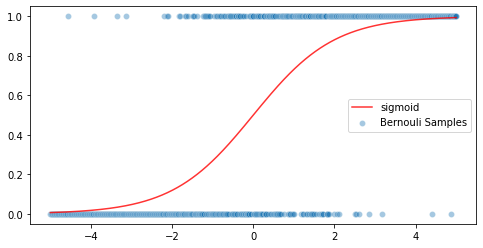

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x=x, y=y_dist.sample(), alpha=0.4, label='Bernouli Samples')
sns.lineplot(x=x, y=(1/(1+torch.exp(-x))), color='red', alpha=0.8, label='sigmoid')

In [26]:
# create a constant input for this model
x = torch.tensor([[0.0]])
y_dist = model(x)
y_dist

Bernoulli(probs: 0.5)

In [27]:
# take samples from the Bernoulli
for _ in range(5):
    print(y_dist.sample())

tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)


### Probabilistic model with wrong weights
Given the samples, will try to learn the weights of the NN that produced these samples

In [55]:
def nll(y, y_dist):
    return -y_dist.log_prob(y)

class LinBern2(pl.LightningModule):
    def __init__(self, init_weight, init_bias, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )
        
        # initialize parameters
        nn.init.constant_(self.model[0].weight, self.hparams.init_weight)
        nn.init.constant_(self.model[0].bias, self.hparams.init_bias)
        
        # store weights
        self.trainable_weights = []
        self.trainable_biases = []
        self.losses = []
        
    def forward(self, x):
        out = self.model(x)
#         print(f'out.shape - {out.shape}')
        return dist.Bernoulli(out.squeeze())
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_dist = self.forward(x)
        loss = nll(y, y_dist).sum()
        self.trainable_weights.append(self.model[0].weight.item())
        self.trainable_biases.append(self.model[0].bias.item())
        self.losses.append(loss)
        self.log('loss', loss)
        return loss
    
    def train_dataloader(self):
        return dl
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
# create y by sampling from the output prob dist of model with right weights
x = torch.linspace(-5, 5, 1000)
y = model(x.unsqueeze(1)).sample()
ds = TensorDataset(x.unsqueeze(1), y)
dl = DataLoader(ds, batch_size=500)

model2 = LinBern2(2,2, learning_rate=0.01)
trainer = pl.Trainer(max_epochs=300)
trainer.fit(model2) 

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2     
/home/achinta/miniconda3/envs/cudf15/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

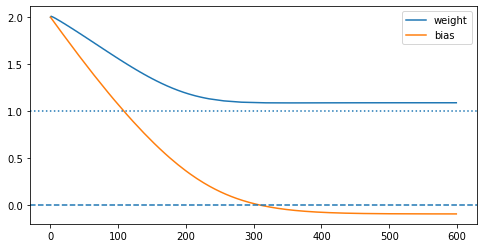

In [62]:
fig, ax = plt.subplots(figsize=(8,4))
num_points = model2.trainable_weights
sns.lineplot(x=range(len(num_points)), y=model2.trainable_weights, label='weight', ax=ax)
sns.lineplot(x=range(len(num_points)), y=model2.trainable_biases, label='bias', ax=ax)
ax.axhline(0.0, ls='--')
ax.axhline(1.0, ls=':')

In [57]:
[o for o in model2.parameters()]

[Parameter containing:
 tensor([[1.0871]], requires_grad=True),
 Parameter containing:
 tensor([-0.0987], requires_grad=True)]